In [1]:
import sys
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os
import numpy as np
import random
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm 
from sklearn import metrics 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def read_multifa(filename): # read fasta files (generated by bedools getfasta)
    id_part=[]
    seq=[]
    for record in SeqIO.parse(filename, 'fasta'):
        id_part.append(record.id)
        seq.append(record.seq)
    return [seq,id_part]
 

In [3]:
def generate_kmers_list(kmerlen): 
    nts = ['A', 'C', 'G', 'T']
    kmers = []
    kmers.append('')
    l = 0
    while l < kmerlen:
        imers = []
        for imer in kmers:
            for nt in nts:
                imers.append(imer+nt)
        kmers = imers
        l += 1

    return kmers


In [4]:
def kmer_counter(seq,kmer_len):
    g_kmers_list=generate_kmers_list(kmer_len)
    kmer_freq=[]
    for lines in seq:
        dic_line=dict(zip(g_kmers_list,[0] * len(g_kmers_list)))
        i=0
        while i < len(lines)-(kmer_len-1):
            if str(lines[i:kmer_len+i]) in dic_line.keys():
                dic_line[str(lines[i:kmer_len+i])] +=1
            i +=1
            
        kmer_freq.append(list(dic_line.values()))
            
    return kmer_freq


In [5]:
def get_idx(lst, value): 
    return [i for i, x in enumerate(lst) if value in x]

In [6]:
def getChr5(valuelist,ids): # group k-mer's into Chr5 and Chr1-4, 
    VA=np.array(valuelist)
    
    idx5=get_idx(ids,'AT5')
    rang=range(0,len(valuelist),1)
    idx1to4=[rang[i] for i in rang if not i in idx5]
    
    scaler = preprocessing.StandardScaler()
    C1to4=scaler.fit_transform(VA[idx1to4,:].transpose()).transpose()
    C5=scaler.fit_transform(VA[idx5,:].transpose()).transpose()
    
    idx_C5=[ids[i] for i in idx5]
    idx_C1to4=[ids[i] for i in idx1to4]
    
    return [C1to4,C5,idx_C1to4,idx_C5]

In [7]:
def scale_freqs(valuelist):
    VA=np.array(valuelist)
    scaler = preprocessing.StandardScaler()
    C=scaler.fit_transform(VA.transpose()).transpose()    
    return C

In [8]:
def choose_random(nparray,ids,num):
    print('array and ids length differ') if nparray.shape[0]!=len(ids) else print('random sampling...')
    randix=np.random.choice(nparray.shape[0],num,replace=False)
    return [nparray[randix,:],[ids[i] for i in randix]]

In [9]:
#take neg posi nparray, stack, label
def make_dataset(P,N):
    X=np.vstack([P,N])
    y=list(np.ones(len(P)))+list(np.zeros(len(N)))
    return [X,y]

In [10]:
def extract_highmer_index(clf,top,bottom):
    X=clf.coef_[0]
    plus_weights_index=np.argpartition(-X, top)[:top] 
    minus_weights_index=np.argpartition(X, bottom)[:bottom]
    highweight_index=np.hstack((plus_weights_index,minus_weights_index))
    print(highweight_index)
    return tuple(highweight_index)


In [11]:
def get_high(C1to4,C5,idx_C5,idx_C1to4,highweight):
    return [C1to4[:,highweight],C5[:,highweight],idx_C5,idx_C1to4]

In [12]:
def get_conf_idx(y_test,X_test,clf):
    rag=range(0,len(y_test),1)
    prd=clf.predict(X_test)
    false_negative_idx=[rag[i] for i in rag if y_test[i] == 1 and prd[i]==0]
    false_positive_idx=[rag[i] for i in rag if y_test[i] == 0 and prd[i]==1]
    true_negative_idx=[rag[i] for i in rag if y_test[i] == 0 and prd[i]==0]
    true_positive_idx=[rag[i] for i in rag if y_test[i] == 1 and prd[i]==1]
    return [true_positive_idx,false_positive_idx,false_negative_idx,true_negative_idx]

In [13]:
#grid search with cross fold validation. 
# For Chr1-4, positive data was divided to 1/cv and negative data was randomly sampled to be the same number of 1/cv-of-positive, and trained. 
def grid_search_sample(Cs,X_test,y_test,nparray_small,nparray_large,cv):
    # split the positive dataset into multiple sub groups. number of subgroup is defined by cv 
    pos_index=[random.randint(1,cv) for i in range(nparray_small.shape[0])]
    neg_index=random.sample([0]*(nparray_large.shape[0]-nparray_small.shape[0]) + pos_index,nparray_large.shape[0])
    index=0
    clfs=[]
    best_score = 0
    best_parameters  = {}
    best_parameter_index  = 0
    for C in Cs:
        score_cv = []
        for k in range(cv):
            k=k+1
            clf = svm.LinearSVC(C=C,max_iter=10000000)
            idx_kp_test=[i for i, x in enumerate(pos_index) if x == k]
            idx_kp_train=[i for i, x in enumerate(pos_index) if x != k]
            idx_kn_test=[i for i, x in enumerate(neg_index) if x == k] 
            idx_kn_train=np.random.choice(nparray_large.shape[0],len(idx_kp_train),replace=False)
            [X_train_cv,y_train_cv]=make_dataset(nparray_small[idx_kp_train,:],nparray_large[idx_kn_train,:])
            [X_test_cv,y_test_cv]=make_dataset(nparray_small[idx_kp_test,:],nparray_large[idx_kn_test,:])
            clf.fit(X_train_cv,y_train_cv)  
            clfs.append(clf)
            score_cv.append(clf.score(X_test_cv,y_test_cv))
        score = np.mean(score_cv)
        if score > best_score:
            best_score = score
            best_parameters = {'C' : C}
            best_parameter_index=index
        index=index+1
    print('Best score on validation set: {}'.format(np.round(best_score,5)))
    print('Best parameters: {}'.format(best_parameters))
    score_test=[]
    best_clfs=[clfs[k] for k in range(best_parameter_index*cv,best_parameter_index*cv+cv)]
    for bclf in best_clfs:
        score_test.append(bclf.score(X_test,y_test))
    print('Test set scores with best parameters: {}'.format(np.round(score_test,5)))
    print(best_parameter_index)
    return best_clfs

In [14]:
# kernel-svm version
def grid_search_kernel_sample(Cs,gammas,X_test,y_test,X_train,y_train,nparray_small,ids_small,nparray_large,ids_large,cv):
    pos_index=[random.randint(1,cv) for i in range(len(ids_small))]
    neg_index=random.sample([0]*(len(ids_large)-len(ids_small)) + pos_index,len(ids_large))
    index=0
    clfs=[]
    best_score = 0
    best_parameters  = {}
    best_parameter_index  = 0
    print('gamma,C,each cv scores,mean score')
    for gamma in gammas:
        for C in Cs:
            clf = svm.SVC(gamma=gamma, C=C)
            score_cv = []
            for k in range(cv):
                k=k+1
                clf = svm.SVC(gamma=gamma, C=C)
                idx_kp_test=[i for i, x in enumerate(pos_index) if x == k]
                idx_kp_train=[i for i, x in enumerate(pos_index) if x != k]
                idx_kn_test=[i for i, x in enumerate(neg_index) if x == k] 
                idx_kn_train=np.random.choice(len(ids_large),len(idx_kp_train),replace=False)
                [X_train_cv,y_train_cv]=make_dataset(nparray_small[idx_kp_train,:],nparray_large[idx_kn_train,:])
                [X_test_cv,y_test_cv]=make_dataset(nparray_small[idx_kp_test,:],nparray_large[idx_kn_test,:])
                clf.fit(X_train_cv,y_train_cv)  
                clfs.append(clf)
                score_cv.append(clf.score(X_test_cv,y_test_cv))
            score = np.mean(score_cv)
            print(gamma,C,np.round(score_cv,5),np.round(score,5))
            if score > best_score:
                best_score = score
                best_parameters = {'gamma' : gamma, 'C' : C}
                best_parameter_index=index
            index=index+1
    print('Best score on validation set: {}'.format(np.round(best_score,5)))
    print('Best parameters: {}'.format(best_parameters))
    score_test=[]
    best_clfs=[clfs[k] for k in range(best_parameter_index*cv,best_parameter_index*cv+cv)]
    for bclf in best_clfs:
        score_test.append(bclf.score(X_test,y_test))
    print('Test set scores with best parameters: {}'.format(np.round(score_test,5)))
    print(best_parameter_index)
    return best_clfs

In [15]:
# write out weights of each best cv models
def output_weights(clfs,mer_n,output_filename):
    kmers=generate_kmers_list(mer_n)
    R=np.array(kmers)
    for clf in clfs:
        X=clf.coef_[0]
        R=np.vstack((R,np.round(X,12)))# write out 
    np.savetxt(output_filename,R.transpose(),fmt="%s")
    return R

In [16]:
def output_FPRTPR(clfs,X_test,y_test,output_filename):
    plt.figure()
    FPR_TPR=[]
    aucscores=[]
    header=[]
    for clf in clfs:
        svmscore=clf.decision_function(X_test)
        fpr, tpr, thresholds=metrics.roc_curve(y_test,svmscore,drop_intermediate=False)
        FPR_TPR.append(fpr)
        header.append('fpr')
        FPR_TPR.append(tpr)
        header.append('tpr')
        aucscores.append(metrics.roc_auc_score(y_test,svmscore))
        print(metrics.roc_auc_score(y_test,svmscore),len(thresholds))
        plt.plot(fpr, tpr, marker='+')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    auc_header=str(np.round(np.mean(aucscores),4))
    with open(output_filename, mode='w') as outfile:
        outfile.writelines((auc_header,'\n',' '.join(header),'\n'))
        np.savetxt(outfile,np.array(FPR_TPR).transpose(),fmt="%.5f") 


In [19]:
os.chdir("fasta")
positive='top_3000_genelist_ATX1_re_150_300AtID_sorted_bound.fasta' # positive dataset sequence (multifasta)
negative='top_3000_genelist_ATX1_re_150_300AtID_sorted_unbound.fasta' # negative dataset sequence (multifasta)
outname_FRPTRPs='ChIP8_ATX1_FPRTPR_forrename_later-validation' #output name for FPR/TPR file
outname_weights='ChIP8_ATX1_weights_for_rename_later_validation' #output name for svm weights

450
450
positive_kmer_count_done
negative_kmer_count_done
Best score on validation set: 0.77262
Best parameters: {'C': 1.52587890625e-05}
Test set scores with best parameters: [0.77    0.76417 0.76333 0.765   0.77   ]
6
0.8335444444444444 1201
0.8394277777777778 1201
0.8323388888888889 1201
0.8365138888888889 1201
0.8360861111111111 1201


array([['AAAAAA', 'AAAAAC', 'AAAAAG', ..., 'TTTTTC', 'TTTTTG', 'TTTTTT'],
       ['-0.007772558269', '-0.000153171131', '0.003041802216', ...,
        '0.000724707118', '0.001406343644', '-0.001653193388'],
       ['-0.005055830471', '0.00140597542', '0.00427796733', ...,
        '-0.001398501263', '0.001950801854', '-0.000282863307'],
       ['-0.007634866493', '0.000639531169', '0.00138926339', ...,
        '0.000476094083', '9.0278657e-05', '-0.001125504056'],
       ['-0.007804846506', '0.000353429128', '0.003818812647', ...,
        '0.000287620282', '0.004970726183', '-0.002498038971'],
       ['-0.007063930339', '4.2991782e-05', '0.005162640577', ...,
        '-4.1095142e-05', '0.00185713464', '-0.003397124133']],
      dtype='<U32')

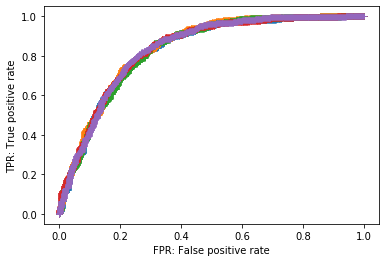

In [21]:
# load data and train
[pseq,pid]=read_multifa(positive)
[nseq,nid]=read_multifa(negative)
print(len(pseq[1]))
print(len(nseq[1]))
k=6 # define k-mer
p_freq=kmer_counter(pseq,k)
print('positive_kmer_count_done')
n_freq=kmer_counter(nseq,k)
print('negative_kmer_count_done')
P=scale_freqs(p_freq)
N=scale_freqs(n_freq)
p_non_test, p_test = train_test_split(P, test_size=0.2)
n_non_test, n_test = train_test_split(N, test_size=p_test.shape[0])
[X_test,y_test]=make_dataset(p_test,n_test)
Cs=[2**(-i) for i in range(10,20,1)]
clfs=grid_search_sample(Cs,X_test,y_test,p_non_test,n_non_test,5)  
# Cs=[2**(-i) for i in  range(-2,2,1)]  # in the case of kernel-svm
# gammas=[2**(-i) for i in range(12,16,1)]  
# clfs_sample=grid_search_kernel_sample(Cs,gammas,X_test,y_test,X_train,y_train,P_1to4,idxp_1to4,N_1to4,idxn_1to4,5) 
output_FPRTPR(clfs,X_test,y_test,outname_FRPTRPs)
output_weights(clfs,k,outname_weights)

In [ ]:
svmscores=[]  
for clf in clfs:
        svmscore=clf.decision_function(X_test)
        svmscores.append(clf.decision_function(X_test))

SCORES=pd.DataFrame(svmscores,columns=idxp_C5+idxn_C5s).T
SCORES.to_csv('ATX1_SVM_scores.csv')